In [2]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import findspark

findspark.init()
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, pandas_udf, col, lower, regexp_replace
from pyspark.sql.types import ( 
    StructType,
    StructField,
    IntegerType,
    StringType,
    ArrayType,
)
from pyspark.ml.feature import (
    CountVectorizer,
    StringIndexer,
    Tokenizer,
    StopWordsRemover,
)
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    DecisionTreeClassifier,
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix
from pyspark.ml import PipelineModel, Pipeline, Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.ml.util import DefaultParamsWritable, DefaultParamsReadable

nltk.download("stopwords")
nltk.download("punkt")

# Define English stopwords
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drstr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\drstr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("Text Classification with PySpark").getOrCreate()

In [4]:
# Load the data
data = spark.read.csv("twitter_training.csv", header=False, inferSchema=True)
validation = spark.read.csv("twitter_validation.csv", header=False, inferSchema=True)

In [5]:
# Define column names
columns = ["id", "Company", "Label", "Text"]

# Rename columns
for i, col in enumerate(columns):
    data = data.withColumnRenamed("_c{}".format(i), col)
    validation = validation.withColumnRenamed("_c{}".format(i), col)

In [6]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Text: string (nullable = true)



In [7]:
# Drop rows with empty 'Text' column
data = data.dropna(subset=["Text"])
validation = validation.dropna(subset=["Text"])

In [8]:
data.select("Text").show(10)

+--------------------+
|                Text|
+--------------------+
|im getting on bor...|
|I am coming to th...|
|im getting on bor...|
|im coming on bord...|
|im getting on bor...|
|im getting into b...|
|So I spent a few ...|
|So I spent a coup...|
|So I spent a few ...|
|So I spent a few ...|
+--------------------+
only showing top 10 rows



In [9]:
# Define the StringIndexer for the label column (index the labels)
label_indexer = StringIndexer(inputCol="Label", outputCol="Label2")

# # Define your index mapping
# class_index_mapping = { "Negative": 0, "Positive": 1, "Neutral": 2, "Irrelevant": 3 }

# Fit StringIndexer on data
label_indexer_model = label_indexer.fit(data)
data = label_indexer_model.transform(data)
validation = label_indexer_model.transform(validation)

# Extract label mapping
label_mapping = label_indexer_model.labels

# Print label mapping
print("Label Mapping:")
for index, label in enumerate(label_mapping):
    print(f"Index {index} --> Label '{label}'")

Label Mapping:
Index 0 --> Label 'Negative'
Index 1 --> Label 'Positive'
Index 2 --> Label 'Neutral'
Index 3 --> Label 'Irrelevant'


In [10]:
def clean_text(df, inputCol="Text", outputCol="cleaned_text"):
    # Remove links starting with https://, http://, www., or containing .com
    df = df.withColumn(
        outputCol,
        regexp_replace(
            df[inputCol], r"https?://\S+|www\.\S+|S+\.com\S+|youtu\.be/\S+", ""
        ),
    )
    # Remove words starting with # or @
    df = df.withColumn(outputCol, regexp_replace(df[outputCol], r"(@|#)\w+", ""))
    # Convert text to lowercase
    df = df.withColumn(outputCol, lower(df[outputCol]))
    # Remove non-alpha characters
    df = df.withColumn(outputCol, regexp_replace(df[outputCol], r"[^a-zA-Z\s]", ""))

    return df

In [11]:
cleaned_data = clean_text(data, inputCol="Text", outputCol="Text")
cleaned_validation = clean_text(validation, inputCol="Text", outputCol="Text")

In [12]:
# Define tokenizer
tokenizer = Tokenizer(inputCol="Text", outputCol="tokens")

# Define stopwords remover
stopwords_remover = StopWordsRemover(
    inputCol="tokens", outputCol="filtered_tokens", stopWords=stop_words
)

# Define CountVectorizer
count_vectorizer = CountVectorizer(
    inputCol="filtered_tokens", outputCol="features", vocabSize=10000, minDF=5
)

# Define Logistic Regression
lr = LogisticRegression(maxIter=10, labelCol="Label2", featuresCol="features")

In [13]:
# create the pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, lr])

# Apply the pipeline to the data
model = pipeline.fit(cleaned_data)
processed_data = model.transform(cleaned_data)

In [14]:
processed_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- Label2: double (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [15]:
processed_data.select("Text", "Label2", "prediction").show()

+--------------------+------+----------+
|                Text|Label2|prediction|
+--------------------+------+----------+
|im getting on bor...|   1.0|       1.0|
|i am coming to th...|   1.0|       1.0|
|im getting on bor...|   1.0|       1.0|
|im coming on bord...|   1.0|       1.0|
|im getting on bor...|   1.0|       1.0|
|im getting into b...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
|so i spent a coup...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
| so i spent a few...|   1.0|       1.0|
|                 was|   1.0|       0.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la vita ...|   2.0|       2.0|
|live rock  hard m...|   2.0|       2.0|
|ihard like me rar...|   2.0|       2.0|
|that was the firs...|   1.0|       1.0|
|this was the firs...|   1.0|       1.0|
+--------------------+------+----------+
only showing top

In [16]:
# Save the model
model.write().overwrite().save("logistic_regression_model")

---


In [17]:
from pyspark.ml import PipelineModel

# Load the model from the directory
loaded_model = PipelineModel.load("logistic_regression_model")

In [18]:
cleaned_validation.show(10)

+-----+--------------------+----------+--------------------+------+
|   id|             Company|     Label|                Text|Label2|
+-----+--------------------+----------+--------------------+------+
| 3364|            Facebook|Irrelevant|i mentioned on fa...|   3.0|
|  352|              Amazon|   Neutral|bbc news  amazon ...|   2.0|
| 8312|           Microsoft|  Negative| why do i pay for...|   0.0|
| 4371|               CS-GO|  Negative|csgo matchmaking ...|   0.0|
| 4433|              Google|   Neutral|now the president...|   2.0|
| 6273|                FIFA|  Negative|hi  ive had madel...|   0.0|
| 7925|           MaddenNFL|  Positive|         thank you  |   1.0|
|11332|TomClancysRainbowSix|  Positive|rocket league sea...|   1.0|
| 1107|      AssassinsCreed|  Positive|my ass still knee...|   1.0|
| 2069|          CallOfDuty|  Negative|fix it jesus  ple...|   0.0|
+-----+--------------------+----------+--------------------+------+
only showing top 10 rows



In [19]:
# Apply the pipeline to the new data
processed_validation = loaded_model.transform(cleaned_validation)

# Optionally, you can select specific columns for evaluation
selected_data = processed_validation.select("id", "Text", "prediction", "Label2")

# Show the processed data
selected_data.show()

+-----+--------------------+----------+------+
|   id|                Text|prediction|Label2|
+-----+--------------------+----------+------+
| 3364|i mentioned on fa...|       3.0|   3.0|
|  352|bbc news  amazon ...|       2.0|   2.0|
| 8312| why do i pay for...|       0.0|   0.0|
| 4371|csgo matchmaking ...|       0.0|   0.0|
| 4433|now the president...|       2.0|   2.0|
| 6273|hi  ive had madel...|       0.0|   0.0|
| 7925|         thank you  |       1.0|   1.0|
|11332|rocket league sea...|       1.0|   1.0|
| 1107|my ass still knee...|       1.0|   1.0|
| 2069|fix it jesus  ple...|       0.0|   0.0|
| 3185|the professional ...|       1.0|   1.0|
| 1172|itching to assass...|       1.0|   1.0|
|11783| hey fred comcast...|       0.0|   0.0|
| 4286|csgo wingman im s...|       2.0|   2.0|
| 8431| game sucks down ...|       0.0|   0.0|
| 9135|congrats to the n...|       1.0|   1.0|
| 4822|    yeah and its fun|       1.0|   1.0|
| 3068|       fuck my life |       0.0|   0.0|
|10537|happy 

Accuracy: 0.878
Confusion Matrix:


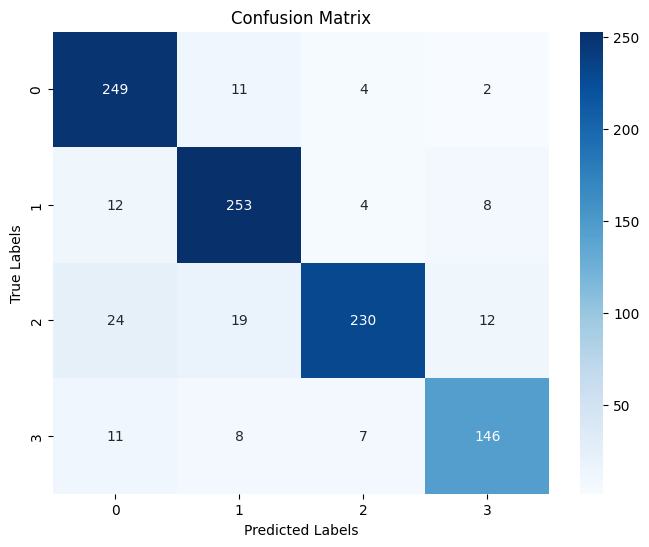

In [20]:
# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="Label2", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(processed_validation)
print("Accuracy:", accuracy)

# --- Create a confusion matrix

# Convert Spark DataFrame to Pandas DataFrame
prediction_and_label_pd = processed_validation.select("prediction", "Label2").toPandas()

# Extract predicted labels and true labels
predicted_labels = prediction_and_label_pd["prediction"].tolist()
true_labels = prediction_and_label_pd["Label2"].tolist()

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [21]:
# Stop SparkSession
spark.stop()